In [250]:
import pandas as pd # KPI-Data Manupilation  
import psycopg2 # Connection with postgres 
from sqlalchemy import create_engine # Connection with postgres 

import yfinance as yf # ticker data 
from sklearn.ensemble import IsolationForest # ml model for anomally detection 

# EDA libraries imports 
import seaborn as sns 
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
 

In [23]:
# connection postgres and create table
conn = psycopg2.connect(
    database="yahoo_finance",
    user='erdmkbc',
    password='admin',
    host='localhost',
    port= '5432'
)

### TO-DO LIST 

### Sorgu taskları 

##### Sorgu Ana Şeması
- Yıl, ay, gün etiketlendirilmeleri sorguları yazılmalı. 
    - Her yılın her ayı için std'ler hesaplanmalı.
    - Her yılın ayrı ayrı ortalamaları, medianları hesaplanmalı. 
    - Ortalama altı ve üstü kalan ayların etiketlendirilmesi.
    - percentage_rank ile ilk çeyrek son çeyrek analizleri yapılmalı.
- Bir öncekinin kapanışı ile bir mevcutun açılışı arasında ki fark. 
- Aynı gün içerisinde ki açılış ve kapanışların farkı / high ve low farkı(dalganlanmalar tespit edilebilir).  
- Son ay verisi.

##### Alt Tablolar
##### KPI Metrikleri
- Senelik, aylık, haftalık analiz raporları(Ortalama, Max, Mın, Std) -DONE
- Sene başı, kapanışı kazanç durumu -DONE 
- Haftalık kazanç durumu(Ortalama, Max, Mın) -DONE
- Günlük kazanç durumu(Ortalama, Max, Mın) - DONE 
- Uzun soluklu(2 Yıllık, 4 yıllık, 8 Yıllık) yatırımların kazanç durumlar - DONE(Pandas manipülasyonu)
- Senelik aykırı değer analizleri - DONE 
- Bir sene içerisinde ki aylık aykırı değer analizleri - DONE 
- Bir sene de düşüş ve yükselişlerin ortalama sayıları - DONE
- Gerçek zamanda son bir ay verisinin kazanç durumu. - DONE
- Ortalama altı ve üstü kalan kapanış değerlerinin sayısı. - DONE

### EDA taskları
- ...

### Model taskları
- ...

In [441]:
### Sorgu taskleri
sql_main_tasks = '''
WITH main_table AS (
                    SELECT 
                    *, 
                    PERCENT_RANK() OVER(ORDER BY "year") AS percent_status_by_year
                    FROM (
                    SELECT 
                        "Open",
                        "High",
                        "Low",
                        "Close",
                        TO_TIMESTAMP("Date"/1000)::date AS date,
                        CAST(EXTRACT(YEAR FROM TO_TIMESTAMP("Date"/1000)::date) AS INT) AS year,
                        EXTRACT(MONTH FROM TO_TIMESTAMP("Date"/1000)::date) AS month,
                        EXTRACT(DAY FROM TO_TIMESTAMP("Date"/1000)::date) AS day,
                        EXTRACT(WEEK FROM TO_TIMESTAMP("Date"/1000)::date) AS week,
        
                        ("High" - "Low") AS high_low_diff,
                        ("Open" - "Close") AS open_close_diff, 
                        ((("Open" - "Close")*100)/"Open") as gain_percentage,
                        (("Open" - "Close")/("High" - "Low")) AS constantly_score


                    FROM btc_usd_data_scheduler) AS nested_query
)
                    {query_part}
                '''

sql_aggregation_query = '''
                        SELECT 
                            "{groupping_elements}",
                                    AVG("{analyz_type}") AS {analyz_type}_avg_by_{groupping_elements},
                                    MAX("{analyz_type}") AS {analyz_type}_max_by_{groupping_elements},
                                    MIN("{analyz_type}") AS {analyz_type}_min_by_{groupping_elements},
                                    STDDEV("{analyz_type}") AS {analyz_type}_std_by_{groupping_elements}

                            FROM main_table
                            {filter_condition} 
                            GROUP BY "{groupping_elements}"
                        '''
sql_periodic_analyz_query = '''
                            ,first_close_in_year AS(
                        SELECT
                            *
                            FROM(
                            
                            SELECT
                            *
                            FROM(
                            SELECT
                            year,
                            CASE WHEN "day" = 1 AND "month" = 1 THEN "Close" ELSE NULL END AS first_close_in_year

                            FROM main_table) AS nested_query WHERE "first_close_in_year" IS NOT NULL) as cte_first_year),
                        last_close_in_year AS(
                            SELECT
                            *
                            FROM(
                            SELECT
                            *
                            FROM(
                            SELECT
                            year,
                            CASE WHEN "day" = 31 AND "month" = 12 THEN "Close" ELSE NULL END AS last_close_in_year

                            FROM main_table) AS nested_query WHERE "last_close_in_year" IS NOT NULL) as cte_first_year)

                            SELECT 
                            *,
                            ((last_close_in_year - first_close_in_year)*100/last_close_in_year) AS gain_status                           
                            FROM(
                            SELECT 
                            *
                            FROM last_close_in_year 
                            LEFT JOIN first_close_in_year USING("year")) AS nested_final
                            
                    '''

sql_periodic_gain = '''
                        SELECT 
                            AVG(gain_percentage) AS avg_gain_percentage,
                            MAX(gain_percentage) AS max_gain_percentage,
                            MIN(gain_percentage) AS min_gain_percentage,
                            {gropping_elements} 
                            
                        FROM main_table 
                            {filter_condition}
                            GROUP BY 4
                            ORDER BY 1 DESC
                    '''

sql_long_time_investment_gain = '''
                        SELECT
                        *
                        FROM(
                        SELECT
                            date,
                            close,
                            open, 
                            (CASE 
                                WHEN (max_date - Date) = 0 THEN 'Last-Day'
                                WHEN (max_date - Date) = 100 THEN '100-Days' 
                                WHEN (max_date - Date) = 200 THEN '200-Days'
                                WHEN (max_date - Date) = 365 THEN '1-Year'
                                WHEN (max_date - Date) = 1825 THEN '5-Year'
                            ELSE NULL END) AS investing_status
                        FROM(
                        SELECT
                            Date AS date, 
                            "Close" AS close,
                            "Open" AS open, 
                            MAX(Date) OVER() AS max_date
                        FROM main_table) AS nested_query) AS nested_query_2 
                                                          WHERE "investing_status" IS NOT NULL
                                                    
                        '''

sql_low_high_status_cnt = '''
                        SELECT 
                            COUNT(low_high_status) AS avg_low_high_status,
                            low_high_status,
                            year
                        FROM(
                            SELECT
                            year, 
                            CASE 
                            WHEN gain_percentage > 0 THEN 'High-Perform'
                            WHEN gain_percentage < 0 THEN 'Low-Perform'
                            ELSE NULL END AS low_high_status  
                        
                        FROM main_table) AS nested_query GROUP BY 2,3
                        '''
sql_last_month_status = '''
                        SELECT 
                        
                        "Open",
                        "Close",
                        "date",
                        ((("Open" - "Close")*100)/"Open") as gain_percentage
                        
                        FROM main_table 
                        WHERE 
                            date_trunc('month', "date") = date_trunc('month', current_date - interval '1 month')
                        ''' 
sql_mean_median_status = '''
                        SELECT 
                            year,
                            mean_status_by_open,
                            COUNT(mean_status_by_open) AS mean_status_by_open_cnt
                        FROM(
                            SELECT
                            *,
                            CASE 
                            WHEN "Open" > avg_open THEN 'Upper-Mean'
                            WHEN "Open" < avg_open THEN 'Lower-Mean'
                            ELSE NULL END AS mean_status_by_open 
                        FROM(
                            SELECT
                            DISTINCT year, 
                            "Open",
                            AVG("Open") OVER(PARTITION BY "year") AS avg_open 
                        FROM main_table) AS nested_query) AS nested_query_2 GROUP BY 1,2
                        '''

sql_outlier_analyz = '''
                    ,outlier_status AS(
                    SELECT 
                    *,
                    CASE  
                    WHEN pct_of_mean > 1.0 THEN 'Upper-2.0 Outlier'
                    ELSE 'Normal-Values' END AS outlier_status
                     
                    FROM(
                        SELECT
                            "Open" AS open,
                            "week" AS week,
                            year,  
                            (("Open") / (AVG("Open") over ())) AS pct_of_mean
                    
                    FROM main_table) AS nested_query WHERE year = {year_condition})

                    SELECT * 
                    FROM outlier_status
                    '''
sql_ticker_raw_table = '''
                    SELECT * 
                    FROM main_table
                    {filter_condition}
                       '''

### EDA Aşaması 

In [466]:
def yearly_aggregations(groupping_elements, analyz_type, filter_condition): 

    # Extract data from kpi data 
    df = pd.read_sql(sql_main_tasks.format(query_part=sql_aggregation_query.format(

                                        groupping_elements = groupping_elements,
                                        analyz_type = analyz_type,
                                        filter_condition = filter_condition 
                                        
                                        )), con = conn)
    # Visiulization chapter 
    fig, axs = plt.subplots(2,2,figsize=(15,15))

    #scatter plot graphs 
    sns.barplot(data = df, 
    x = 'year', 
    y = 'close_avg_by_year', 
    color = 'red', 
    alpha = 0.8, 
    label = 'mean',
    ax = axs[0][0])
    axs[0][0].set_xlabel('Years', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[0][0].set_ylabel('Means', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[0][0].set_title('Mean close by year BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    
    sns.barplot(data = df, 
    x = 'year', 
    y = 'close_max_by_year', 
    color = 'red', 
    alpha = 0.8, 
    label = 'max',
    ax = axs[1][0])
    axs[1][0].set_xlabel('Years', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[1][0].set_ylabel('Max', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[1][0].set_title('Max close by year BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})

    sns.barplot(data = df, 
    x = 'year', 
    y = 'close_min_by_year', 
    color = 'red', 
    alpha = 0.8, 
    label = 'min',
    ax = axs[1][1])
    axs[1][1].set_xlabel('Years', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[1][1].set_ylabel('Min', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[1][1].set_title('Min close by year BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})

    sns.barplot(data = df, 
    x = 'year', 
    y = 'close_std_by_year', 
    color = 'red', 
    alpha = 0.8, 
    label = 'min',
    ax = axs[0][1])
    axs[0][1].set_xlabel('Years', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[0][1].set_ylabel('Min', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[0][1].set_title('Std close by year BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.savefig("aggregation.png", dpi=300)
    plt.show()   
        

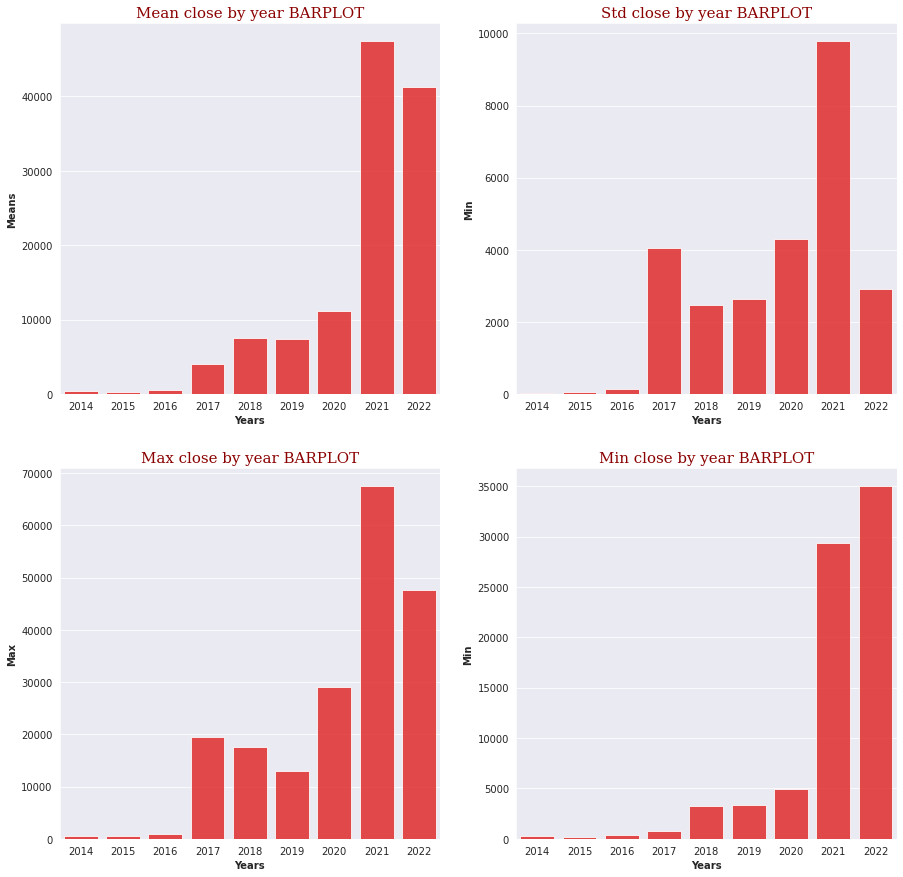

In [467]:
yearly_aggregations(groupping_elements = 'year',
                    analyz_type = 'Close',
                    filter_condition = None)

In [468]:
def periodic_gain_invesment(gropping_elements, filter_condition,year):

    # Extract data from kpi data 
    df = pd.read_sql(sql_main_tasks.format(query_part=sql_periodic_gain.format(
                                                                                gropping_elements = gropping_elements,
                                                                                filter_condition = filter_condition
                                                                                            )), con = conn)

    # Visiulization chapter 
    fig, axs = plt.subplots(3,figsize=(15,20))
    sns.barplot(data = df, 
    x = 'month', 
    y = 'avg_gain_percentage', 
    color = 'red', 
    alpha = 0.8, 
    label = 'mean',
    ax = axs[0])
    axs[0].set_xlabel('Month', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[0].set_ylabel('Gain-Percentage-MEAN', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[0].set_title('Mean gain percentage by month BARPLOT-{year}'.format(year=year),fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    
    sns.barplot(data = df, 
    x = 'month', 
    y = 'max_gain_percentage', 
    color = 'red', 
    alpha = 0.8, 
    label = 'max',
    ax = axs[1])
    axs[1].set_xlabel('Month', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[1].set_ylabel('Gain-Percentage-MAX', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[1].set_title('Max gain percentage by month BARPLOT-{year}'.format(year=year),fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    
    sns.barplot(data = df, 
    x = 'month', 
    y = 'min_gain_percentage', 
    color = 'red', 
    alpha = 0.8, 
    label = 'min',
    ax = axs[2])
    axs[2].set_xlabel('Month', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[2].set_ylabel('Gain-Percentage-MIN', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs[2].set_title('Min gain percentage by month BARPLOT-{year}'.format(year=year),fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.savefig("invesment_type.png", dpi=300)
    plt.show()

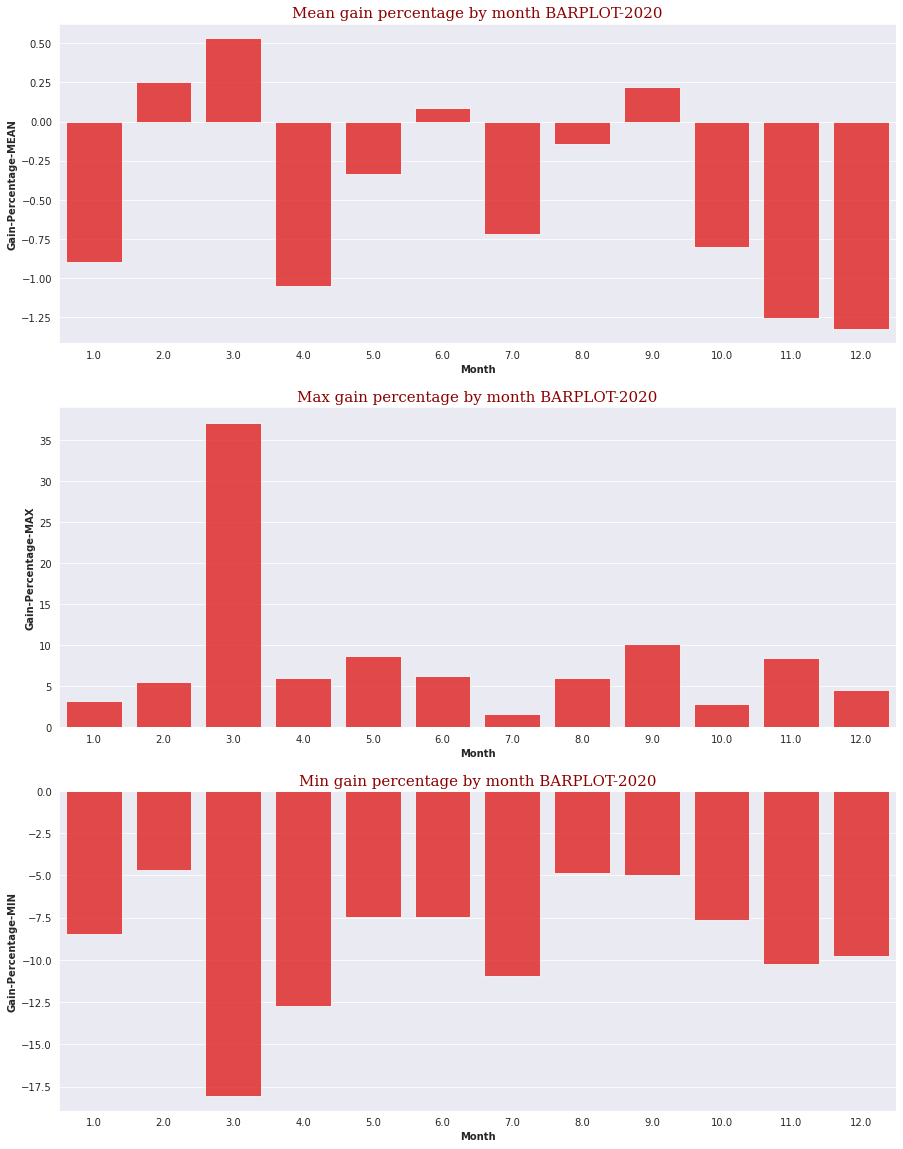

In [469]:
periodic_gain_invesment(gropping_elements = 'month', filter_condition = 'WHERE "year" = 2020', year = '2020')

In [470]:
def investing_type_gain_percentages(*op_args):
    
    df = pd.read_sql(sql_main_tasks.format(query_part = sql_long_time_investment_gain), con = conn)
    # pandas manipulation  
    df['gain_invest_type'] = (((df[df['investing_status'] == 'Last-Day'].close.values[0])- df['open'])*100)/(df['close'])

    # Visiulization chapter 
    fig, axs = plt.subplots(figsize=(10,10))
    sns.barplot(data = df, 
    x = 'investing_status', 
    y = 'gain_invest_type', 
    color = 'red', 
    alpha = 0.8, 
    label = 'mean',
    ax = axs)
    axs.set_xlabel('Month', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Gain-Percentage-MEAN', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Mean gain percentage by month BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.savefig("invesment_gain.png", dpi=300)
    plt.show()


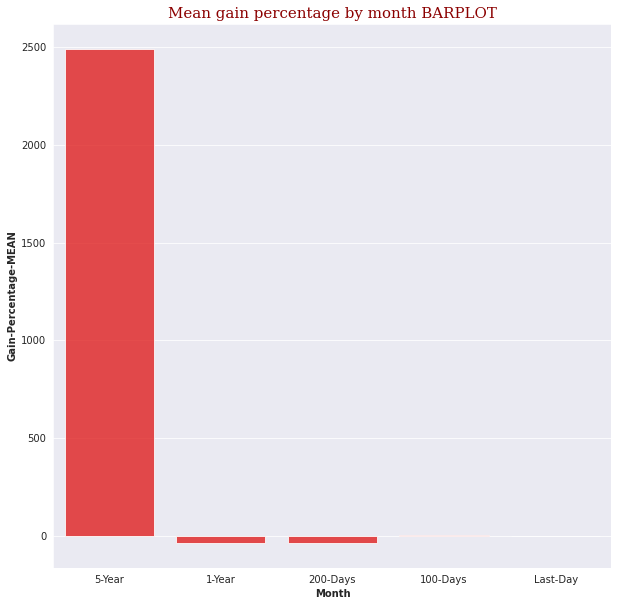

In [471]:
investing_type_gain_percentages()

In [472]:
def high_low_status_by_yearly(*op_args):
    
    # Extract KPI data from schedulered postgres 
    df = pd.read_sql(sql_main_tasks.format(query_part = sql_low_high_status_cnt), con = conn)
    
    # Visiulization chapter 
    fig, axs = plt.subplots(figsize=(20,15))
    sns.barplot(data = df, 
    x = 'year', 
    y = 'avg_low_high_status', 
    hue = 'low_high_status',
    palette=["C0", "C1"], 
    alpha = 0.8, 
    ax = axs)
    axs.set_xlabel('Year', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('High-Low/Perform Count', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('High-Low perform by year BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.savefig("high_low_status.png", dpi=300)
    plt.show()
    

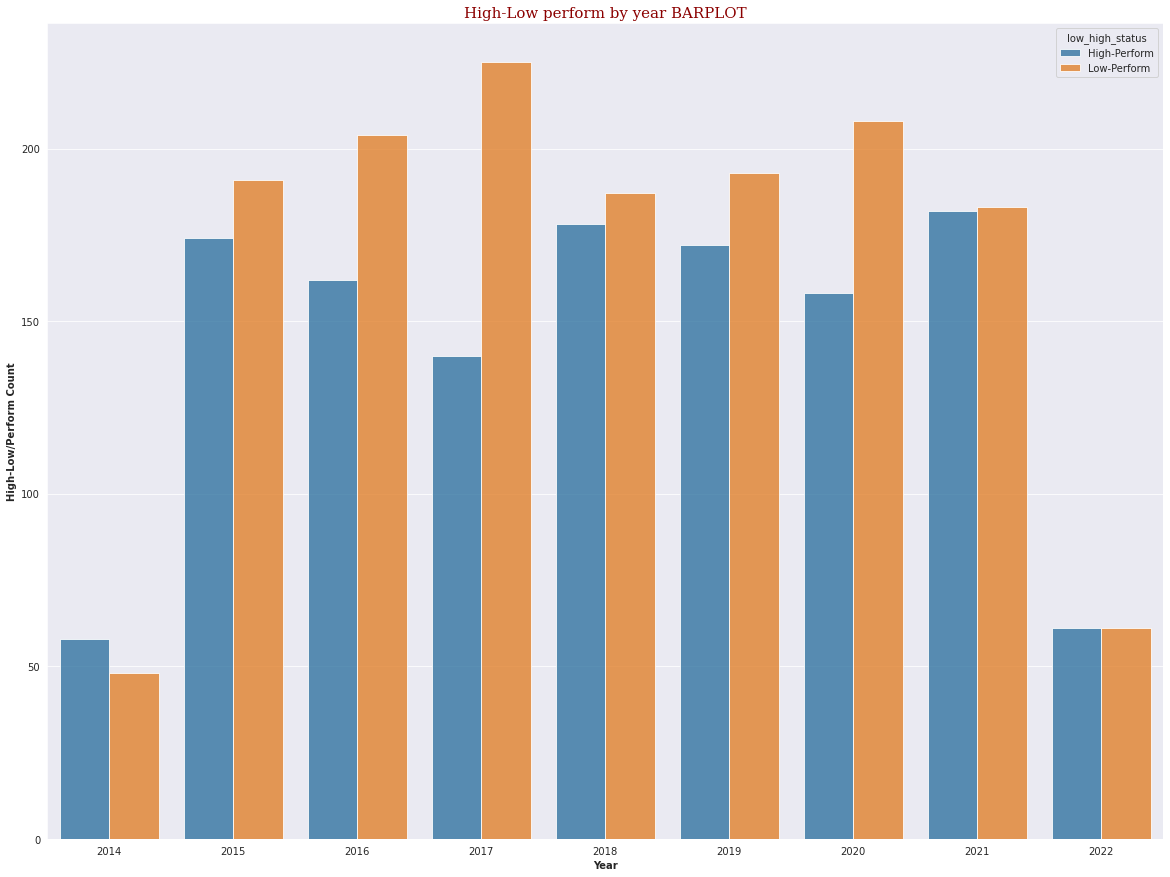

In [473]:
high_low_status_by_yearly()

In [474]:
def last_month_status(*op_args):
    
    # Extract KPI data from schedulered postgres 
    df = pd.read_sql(sql_main_tasks.format(query_part = sql_last_month_status), con = conn)
    # Sorting by date
    df = df.sort_values(by = 'date')

    # Visiulization chapter 
    fig, axs = plt.subplots(figsize=(20,10))
    sns.lineplot(data = df, 
    x = 'date', 
    y = 'Open', 
    color = 'red', 
    label = 'Open',
    linewidth = 5,
    alpha = 0.8, 
    ax = axs)
    plt.xticks(rotation = 45)
    axs.set_xlabel('Date', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Open/Close', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Last Month Status BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})

    sns.lineplot(data = df, 
    x = 'date', 
    y = 'Close', 
    color = 'black', 
    label = 'Close',
    linewidth = 5,
    alpha = 0.8, 
    ax = axs)
    plt.xticks(rotation = 45)
    axs.set_xlabel('Date', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Open/Close', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Last Month Status BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.legend()
    plt.savefig("last_month.png", dpi=300)
    plt.show()


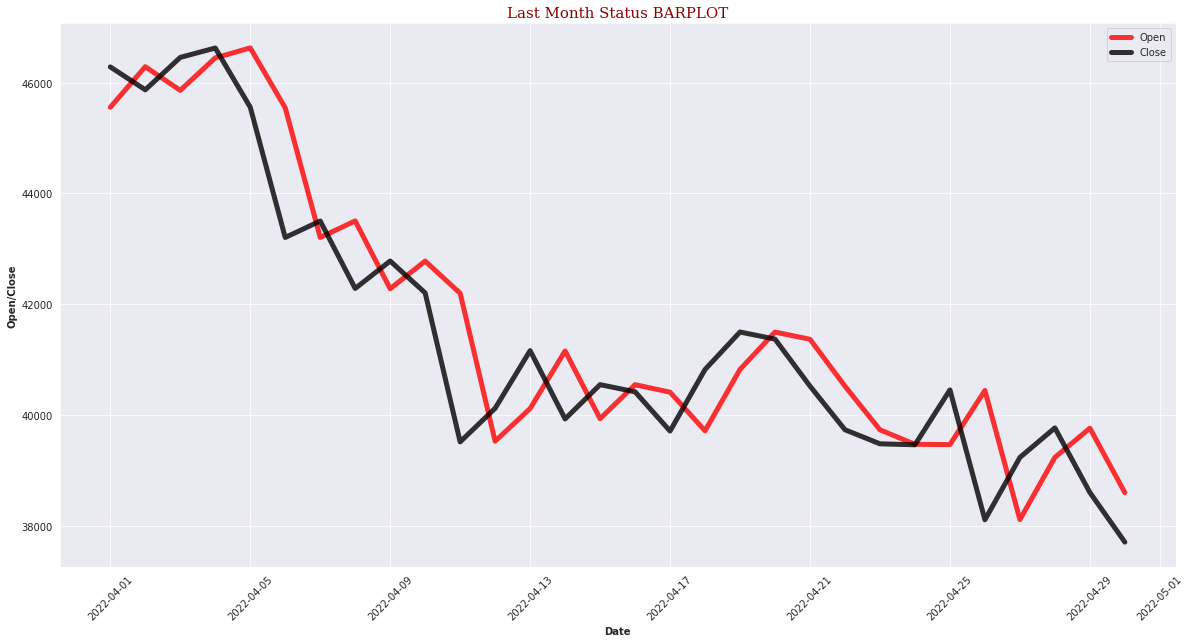

In [475]:
last_month_status()

In [476]:
def mean_status(*op_args):

    # Extract KPI data from schedulered postgres 
    df = pd.read_sql(sql_main_tasks.format(query_part = sql_mean_median_status), con = conn)
    df = df.sort_values(by = 'year')
    # Visiulization chapter 
    
    fig, axs = plt.subplots(figsize=(20,10))
    sns.barplot(data = df, 
    x = 'year', 
    y = 'mean_status_by_open_cnt', 
    hue = 'mean_status_by_open',
    palette=["C0", "C1"], 
    alpha = 0.8, 
    ax = axs)
    plt.xticks(rotation = 45)
    axs.set_xlabel('Year', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Mean-Status-CNT', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Mean-Status BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.savefig("mean_status.png", dpi=300)
    plt.show()


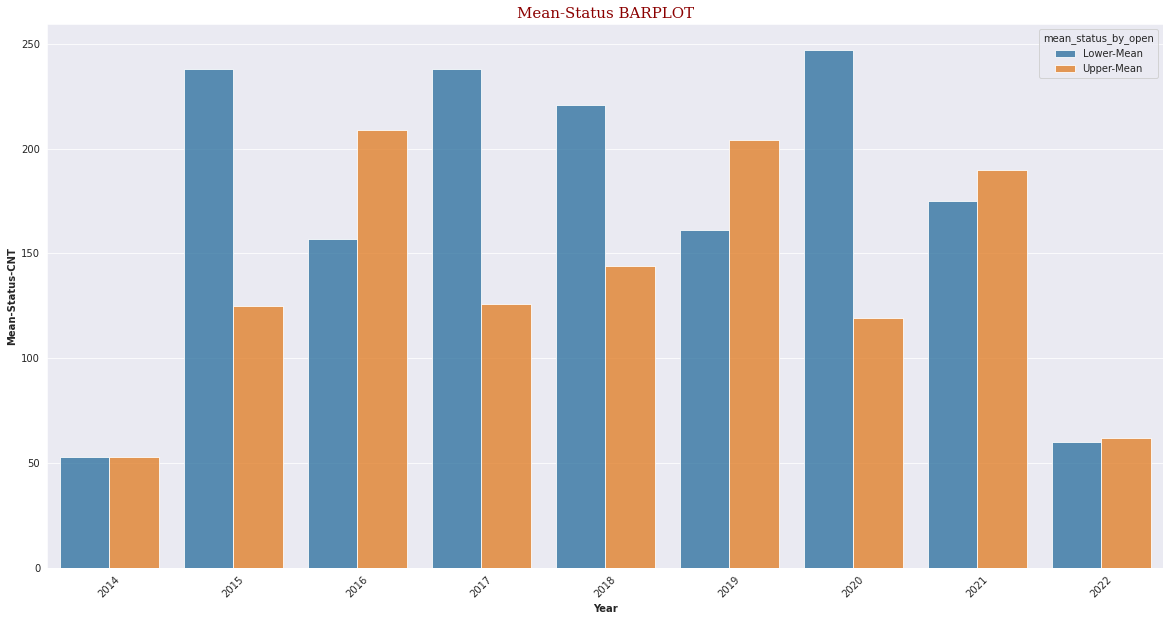

In [477]:
mean_status()

In [478]:
def outlier_detection(year):
    
    # Extract KPI data from schedulered postgres 
    df = pd.read_sql(sql_main_tasks.format(query_part = sql_outlier_analyz.format(
                                                                                    year_condition = year
                                                                                    )), con = conn)
    df = df.sort_values(by = 'open')

    # Visiulization chapter 
    
    fig, axs = plt.subplots(figsize=(20,10))
    sns.lineplot(data = df, 
    x = 'week', 
    y = 'open', 
    palette=['blue'], 
    alpha = 0.8, 
    ax = axs)
    plt.xticks(rotation = 45)
    axs.set_xlabel('Time-Series', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Open', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Outlier-Detection BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    
    sns.scatterplot(data = df[df['outlier_status'] == 'Upper-2.0 Outlier'], 
    x = 'week', 
    y = 'open', 
    color='red', 
    alpha = 0.8, 
    ax = axs)
    plt.xticks(rotation = 45)
    axs.set_xlabel('Time-Series', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Open', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Outlier-Detection BARPLOT-{year}'.format(year = year),fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.savefig("outlier_detection.png", dpi=300)
    plt.show()


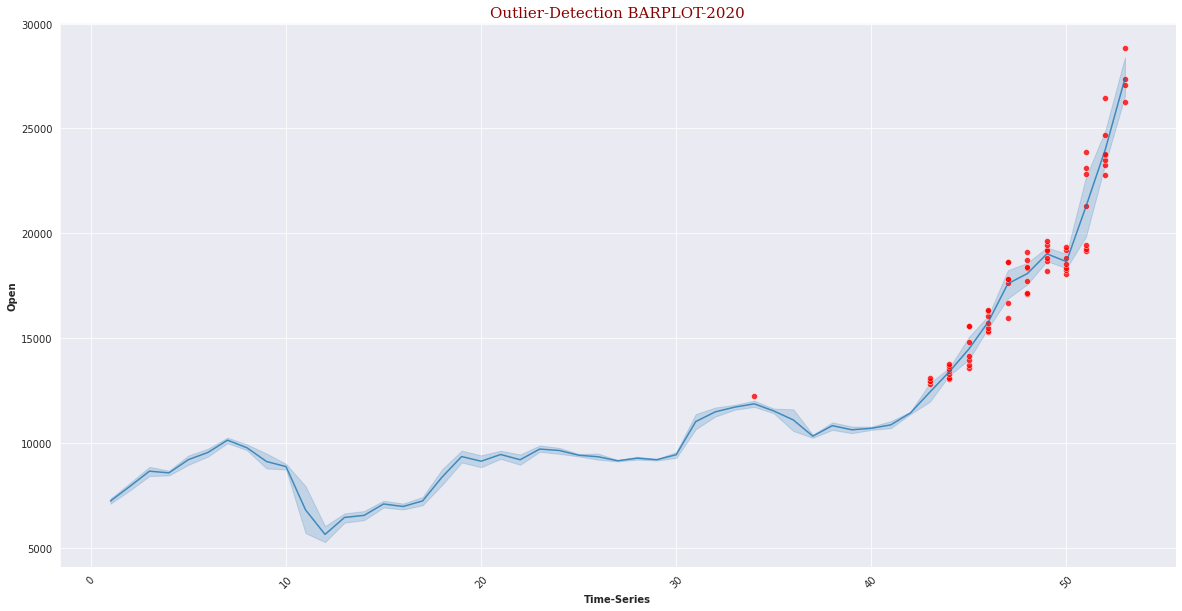

In [479]:
outlier_detection(year='2020')

### Model parts for anomally detection with (Isolation-Forest/Kmeans)

In [444]:
def isolation_forest_anomally_detect():
    
    df = pd.read_sql(sql_main_tasks.format(query_part = sql_ticker_raw_table.format(filter_condition = None)), con = conn)
    
    # model building 
    clf=IsolationForest(n_estimators=100, 
                        max_samples='auto', 
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=42, 
                        verbose=0)
    
    # copy the df 
    df_anomally = df.copy()
    
    # fitting processes 
    clf.fit(df_anomally['Close'].values.reshape(-1,1))
    pred = clf.predict(df_anomally['Close'].values.reshape(-1,1))

    # labelling outliers
    df_anomally['anomally'] = pred
    return df_anomally 

In [446]:
df_anomally = isolation_forest_anomally_detect()

In [480]:
def anomally_detection(df):

    fig, axs = plt.subplots(figsize=(20,10))
    sns.lineplot(data = df, 
    x = 'date', 
    y = 'Close', 
    palette=['blue'], 
    alpha = 0.8, 
    ax = axs)
    plt.xticks(rotation = 45)
    axs.set_xlabel('Time-Series', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Open', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Anomally-Detection BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    
    sns.scatterplot(data = df[df['anomally'] == -1], 
    x = 'date', 
    y = 'Close', 
    color='red', 
    alpha = 0.8, 
    ax = axs)
    plt.xticks(rotation = 45)
    axs.set_xlabel('Time-Series', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_ylabel('Open', fontdict= { 'fontsize': 10, 'fontweight':'bold','fontfamily':'Lucid'})
    axs.set_title('Anomally-Detection BARPLOT',fontdict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15})
    plt.savefig("anomally_detection_if.png", dpi=300)
    plt.show()



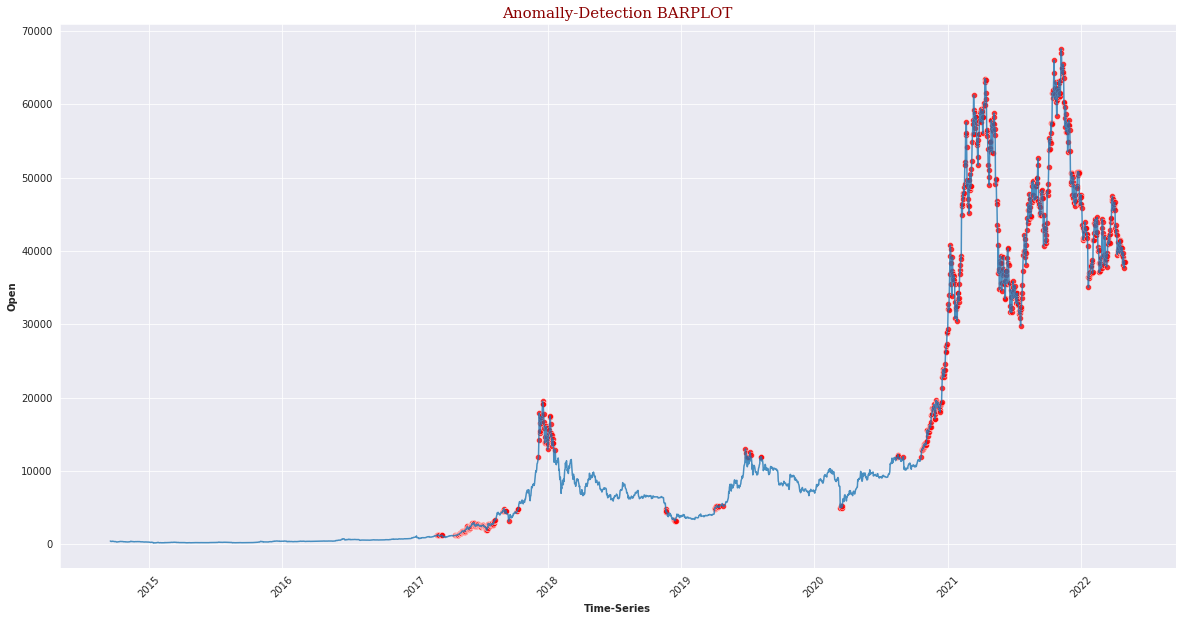

In [481]:
anomally_detection(df_anomally)